In [170]:
import os

def datasets(path, dataset_names):
    '''
    Loads all of the available datasets in a given directory.
    '''
    
    for name in filter(lambda name : name.lower().replace("_", " ")[2:-4] in [name.lower() for name in dataset_names], sorted(os.listdir(path))):
        file_path = os.path.join(path, name)
        
        if os.path.isfile(file_path):
            yield csv.reader(open(os.path.join(path, name)))

In [171]:
import csv

def collect_data(countries, dataset_names):
    # Now, we're going to load the data
    data = datasets("le_data", dataset_names)

    # And parse the data
    country_data = {}

    # Load entries for each country across each of the available data sets at once
    for i, sources in enumerate(zip(*data)):
        # Skip any empty rows
        if len(sources[0]) <= 1:
            continue

        # The name of the current country is always stored in the first CSV column
        country = sources[0][0]

        if country in countries:
            # We'll want to collect our data from each of the provided datasets
            compiled_data = {}

            for j, source in enumerate(sources):
                # There's a bunch of padding by default
                data = source[4:-1]
                fixed_data = []

                for k, entry in enumerate(data):
                    # Try to fill any gaps in the data
                    if entry == "":
                        if k == 0:
                            entry = float(next(filter(lambda x : x != "", data)))
                        else:
                            entry = fixed_data[k - 1]
                    else:
                        entry = float(entry)
                    fixed_data.append(entry)
                compiled_data[dataset_names[j]] = fixed_data
            # Make sure we're allocating enough dates to fit the final plot of the data
            compiled_data["year"] = list(range(1960, 1960 + len(compiled_data[dataset_names[0]])))

            country_data[sources[0][0]] = compiled_data
    return country_data

In [257]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy

%matplotlib inline

In [312]:
plt.rcParams["figure.figsize"] = 16, 9

def plot_data(country_data, plot_name, base_dataset):
    plt.figure(figsize=(16, 9))

    _, subplots = plt.subplots(len(country_data.keys()), len(country_data[list(country_data.keys())[0]].keys()) - 2)
    subplots = subplots if any(isinstance(el, list) for el in subplots) else list(map(lambda subplot : [subplot], subplots))

    for i, country in enumerate(country_data):
        data = country_data[country]

        for j, (dataset_name, dataset) in enumerate(list(filter(lambda key_value_pair : key_value_pair[0] != "year" and key_value_pair[0] != base_dataset, data.items()))):
            ax = subplots[i][j]
            ax.grid(True)

            ax2 = ax.twinx()

            ax.title.set_text("%s: %s vs %s" % (country, dataset_name, base_dataset))

            ax.set_xlabel("year")
            ax.set_ylabel(dataset_name)
            ax.yaxis.set_major_locator(plt.MaxNLocator(15))
            focus_line = ax.plot(data["year"], dataset, marker="", linewidth=2, label=dataset_name)

            ax2.set_ylabel(base_dataset)
            ax2.yaxis.set_major_locator(plt.MaxNLocator(15))
            comp_line = ax2.plot(data["year"], data[base_dataset], color="tab:purple", marker="", linewidth=2, label=base_dataset)
            correlation = numpy.corrcoef(data[base_dataset], dataset)[0, 1]
            corr_line = ax2.plot(data["year"], [correlation * max(data[base_dataset])] * len(data["year"]), marker="", linewidth=2, color="tab:grey", label="Correlation (%f)" % correlation)

            lines = focus_line + comp_line + corr_line
            labels = [l.get_label() for l in lines]

            ax.legend(lines, labels, fancybox=True, framealpha=0.75, loc=0)
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

<Figure size 1152x648 with 0 Axes>

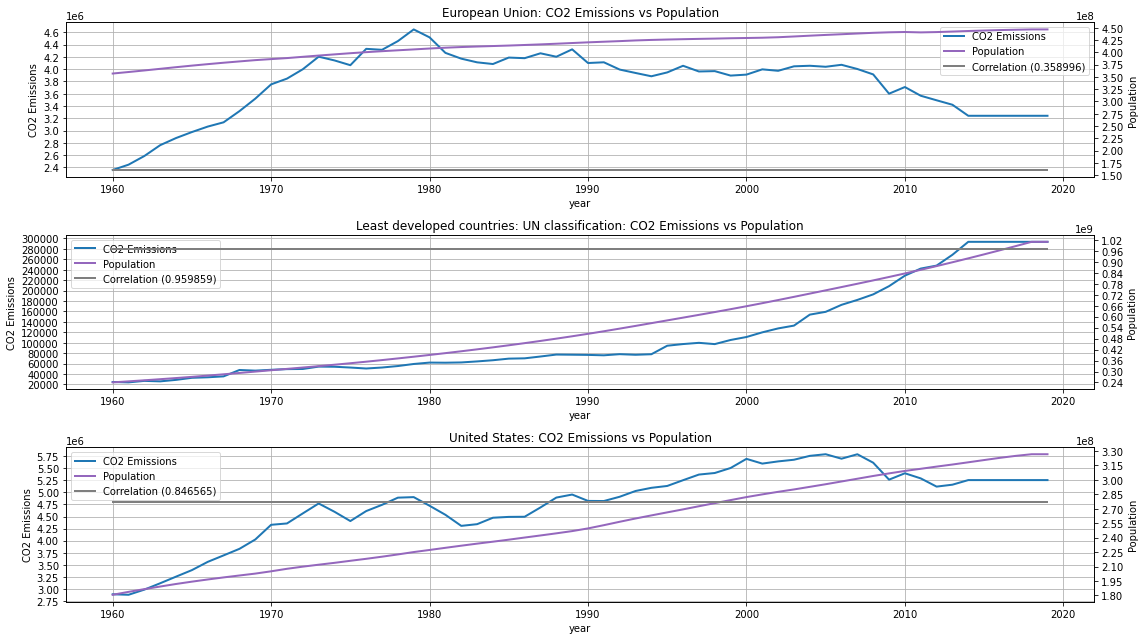

In [317]:
# Let's analyze CO2 emissions vs population in various countries
countries = ["Least developed countries: UN classification", "United States", "European Union"]

collected_data = collect_data(countries, ["CO2 Emissions", "Population"])

plot_data(collected_data, "population_vs_co2_emissions.png", "Population")

<Figure size 1152x648 with 0 Axes>

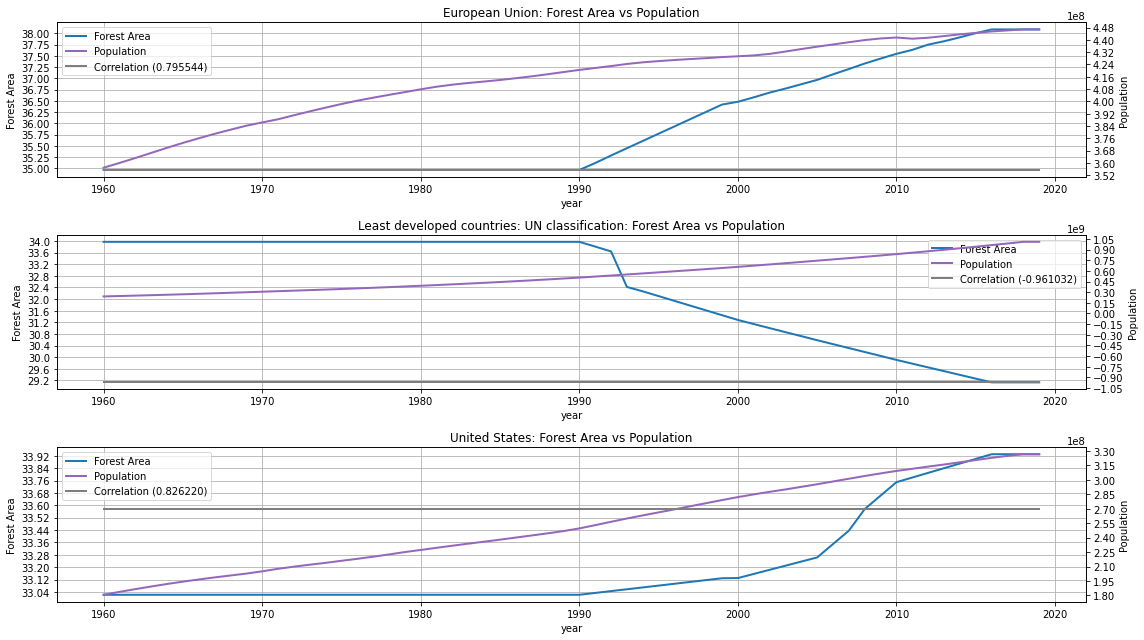

In [318]:
collected_data = collect_data(countries, ["Population", "Forest Area"])

plot_data(collected_data, "population_vs_forest_area_percent.png", "Population")

<Figure size 1152x648 with 0 Axes>

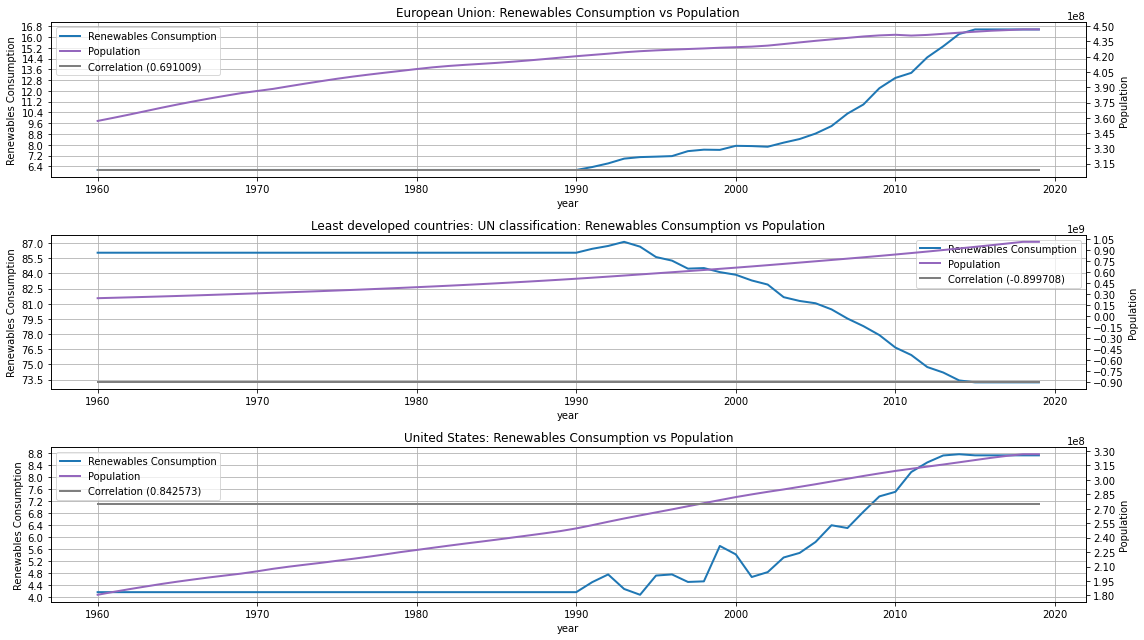

In [319]:
collected_data = collect_data(countries, ["Population", "Renewables Consumption"])

plot_data(collected_data, "population_vs_renewables_consumption_percent.png", "Population")